<a href="https://colab.research.google.com/github/kaxmarc/statistics_ml/blob/main/group_exercises/exercise_2/Group_Exercise_2_PART_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chapter 2- Group Exercise 2 - Regression Analysis and Feature Selection**

**Group Exercise 2**

Group consisting of Ritu, Vikrant Singh and Kay Müller

Dataset "House Prices - Advanced Regression Techniques"

The dataset contains properties with various environmental variables.

Source:

https://www.kaggle.com/datasets/rishitaverma02/house-prices-advanced-regression-techniques

# **Step 0:- (Importing desired Libraries)**

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score


# **1. Preprocessing.**

# **Step 1.1:-**
Handling the missing values.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/kaxmarc/statistics_ml/refs/heads/main/datasets/train_house.csv') # RAW Data from GitHub
#house_data.head()
print("Shape:", df.shape)
print("\nMissing values:")
print(df.isnull().sum().sort_values(ascending=False))

Shape: (1460, 81)

Missing values:
PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
MasVnrType        872
                 ... 
MoSold              0
YrSold              0
SaleType            0
SaleCondition       0
SalePrice           0
Length: 81, dtype: int64


# Displaying numerical and categorical columns:-

In [3]:
numerical_columns = df.select_dtypes(include=['int64','float64']).columns
print("Numerical Columns:- \n")
print(numerical_columns)
print("\nCategorical columns:-\n")
categorical_columns = df.select_dtypes(include=['object']).columns
print(categorical_columns)

Numerical Columns:- 

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

Categorical columns:-

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'Bsmt

# ***Step 1:-***

# **1.1. Handling Missing Values**
Identify missing values

Apply appropriate imputation methods (mean, median, mode, or justified alternative)

In [29]:
from pandas.core.arrays import categorical
numerical_columns = df.select_dtypes(include=['int64','float64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns
# numerical imputation
imput_median = SimpleImputer(strategy="median")
imput_mean = SimpleImputer(strategy="mean")

for feature in numerical_columns:

  if df[feature].isnull().sum().mean() == 0:  # if none are missing
    continue                                  # continue in the loop

  print(f"Numerical Feature {feature} missing: {df[feature].isnull().sum()}")
  if df[feature].skew() > 1 or df[feature].skew() < -1:
    # imput_median
    df[[feature]] = imput_median.fit_transform(df[[feature]])
    print(f"Numerical Feature {feature} imputed {imput_median.strategy}")
  else:
    # imput_mean
    df[[feature]] = imput_mean.fit_transform(df[[feature]])
    print(f"Numerical Feature {feature} imputed {imput_mean.strategy}")


# categorical imputation
imputer_mode = SimpleImputer(strategy="most_frequent")

for feature in categorical_columns:
  if df[feature].isnull().sum() == 0:
    continue

  print(f"Categorical Feature {feature} missing: {df[feature].isnull().sum()}")
  df[[feature]] = imputer_mode.fit_transform(df[[feature]])
  print(f"Categorical Feature {feature} imputed {imputer_mode.strategy}")

# Adjusted features
print("\nAdjusted features:")
print(df.isnull().sum().sort_values(ascending=False))



Adjusted features:
Id                         0
MSSubClass                 0
MSZoning                   0
LotFrontage                0
LotArea                    0
                          ..
SaleType                   0
SaleCondition              0
SalePrice                  0
SalePrice_z_score          0
SalePrice_log_transform    0
Length: 83, dtype: int64


In [28]:
numerical_columns = df.select_dtypes(include=['int64','float64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

# numerical imputation
imput_median = SimpleImputer(strategy="median")
imput_mean = SimpleImputer(strategy="mean")

# categorical imputation
imput_mode = SimpleImputer(strategy="most_frequent")


Explanation:

Mean is the better choice for symmetrical distributions, whereas median should be chosen for distributions with outliers and skewness. The categories are determined based on frequency.

# **1.2. Handling Outliers**
Detect outliers using Z-score

Handle them via removal or transformation


**A visual representation before outlier handling:-**

---





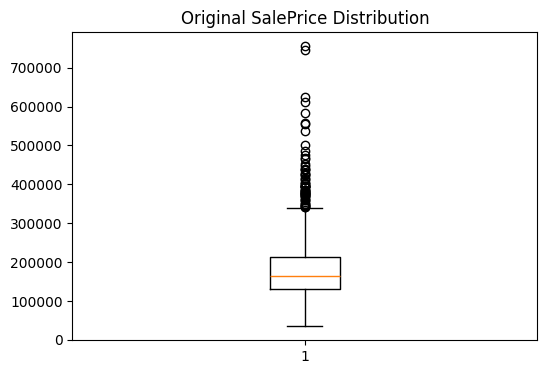

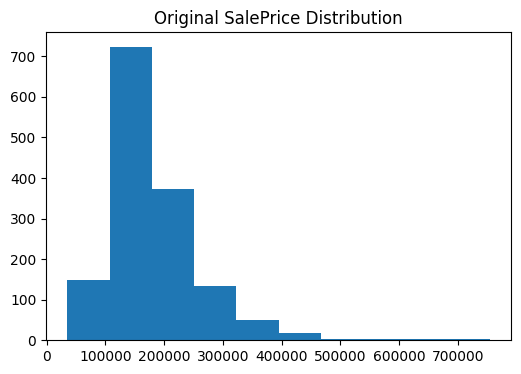

In [6]:
plt.figure(figsize=(6,4))
plt.boxplot(df['SalePrice'])
plt.title("Original SalePrice Distribution")
plt.show()
plt.figure(figsize=(6,4))
plt.hist(df['SalePrice'])
plt.title("Original SalePrice Distribution")
plt.show()

**Handling Outliers:-**

---



In [7]:
df['SalePrice_z_score'] = zscore(df['SalePrice'])

outliers = df[np.abs(df['SalePrice_z_score']) > 3]

print("Outliers:", len(outliers))

Outliers: 22


**We have 22 outliers here.**
# **TREATMENTS:-**

Deleted outliers: 22


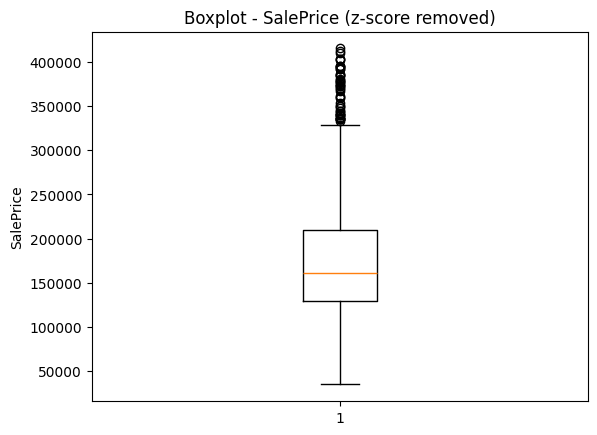

In [30]:
threshold = 3  # Outliers (> 99.7% of normal distribution)
df_no_outliers = df[np.abs(df['SalePrice_z_score']) <= threshold]

print("Deleted outliers:", len(df) - len(df_no_outliers))

plt.boxplot(df_no_outliers['SalePrice'])
plt.title('Boxplot - SalePrice (z-score removed)')
plt.ylabel('SalePrice')
plt.show()


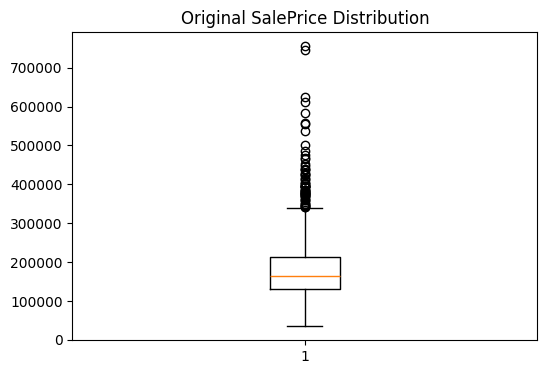

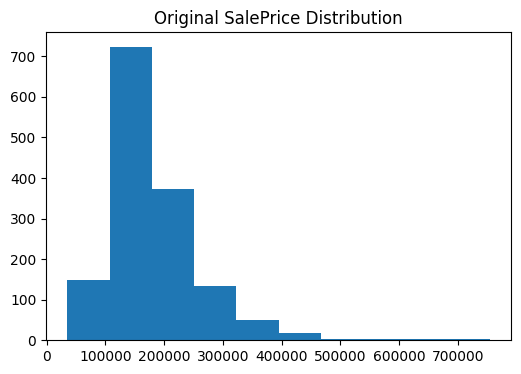

In [10]:
plt.figure(figsize=(6,4))
plt.boxplot(df['SalePrice'])
plt.title("Original SalePrice Distribution")
plt.show()
plt.figure(figsize=(6,4))
plt.hist(df['SalePrice'])
plt.title("Original SalePrice Distribution")
plt.show()

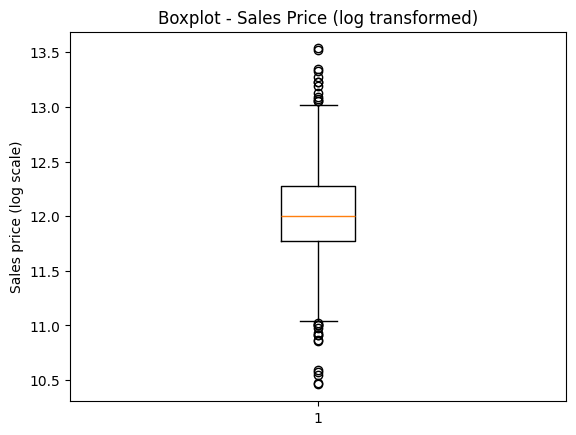

In [9]:
# Reduce outliers using log1p transformation

df['SalePrice_log_transform'] = np.log1p(df['SalePrice'])

plt.boxplot(df['SalePrice_log_transform'])
plt.title('Boxplot - Sales Price (log transformed)')
plt.ylabel('Sales price (log scale)')
plt.show()

Conclusion:

Eliminating outliers using Z-scores is not necessarily useful here, as the authenticity of the core data is not preserved and extreme outliers are eliminated. For example, luxury properties may be just as relevant to the price structure of other properties. Log transformation is the better choice here.

**A visual representation after outlier handling:-**

# **2. Scaling Numerical Features**
Apply Z-score standardization

Apply Min–Max normalization


In [31]:
features = ['YearBuilt', 'SalePrice']
X = df[features].copy()

# Standardisation (Z-Score)
z_scaler = StandardScaler()
z_X = z_scaler.fit_transform(X)
z_X = pd.DataFrame(z_X, columns=[f + '_z' for f in features])

# Normalisation (Min-Max)
mm_scaler = MinMaxScaler()
mm_X = mm_scaler.fit_transform(X)
mm_X = pd.DataFrame(mm_X, columns=[f + '_mm' for f in features])

print("Z-score (first 5 rows):")
display(z_X.head())

print("Min-Max (first 5 rows):")
display(mm_X.head())


Z-score (first 5 rows):


,YearBuilt_z,SalePrice_z
0,1.050994,0.347273
1,0.156734,0.007288
2,0.984752,0.536154
3,-1.863632,-0.515281
4,0.951632,0.869843


Min-Max (first 5 rows):


,YearBuilt_mm,SalePrice_mm
0,0.949275,0.241078
1,0.753623,0.203583
2,0.934783,0.261908
3,0.311594,0.145952
4,0.927536,0.298709


Explanation

Z-score is preferable when data is approximately symmetrical/normally distributed. Each variable is given equal weighting. The Z-score is better suited to dealing with outliers. Min-max scaling, on the other hand, is useful when dealing with limited ranges, e.g. 0–1, i.e. features are required within strict limits.

# **3. Feature Selection**


In [32]:
from sklearn.linear_model import Lasso

# Basic version
X = df[['YearBuilt', 'LotArea']].copy()
y = df['SalePrice'].copy()

# handle missing values quickly for this simple version
X = X.fillna(X.median(numeric_only=True))
y = y.fillna(y.median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lasso = Lasso(alpha=0.1, random_state=42)
lasso.fit(X_scaled, y)

print("Lasso coefficients (YearBuilt, LotArea):", lasso.coef_)


Lasso coefficients (YearBuilt, LotArea): [41236.17823986 20366.40297611]


**Version 2: Lasso optimised with more influencing factors, scaler and training**

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

# Feature grouping (splitting)
numerical_cols = ['YearBuilt', 'LotArea', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea']
categorical_cols = ['Neighborhood']

X = df[numerical_cols + categorical_cols].copy()
y = df['SalePrice'].copy()

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Lasso pipeline
lasso_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Lasso(alpha=0.01, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

lasso_model.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

**Note: Coefficient indicates the direction and strength of influence, while AbsCoeff focuses only on the strength or importance of influence.**

,Feature,Coefficient,AbsCoeff
27,Neighborhood_StoneBr,69826.632664,69826.632664
21,Neighborhood_NridgHt,64857.193966,64857.193966
20,Neighborhood_NoRidge,61644.102147,61644.102147
29,Neighborhood_Veenker,56424.882336,56424.882336
11,Neighborhood_Crawfor,42922.633130,42922.633130
9,Neighborhood_ClearCr,31435.085383,31435.085383
3,GrLivArea,24604.833954,24604.833954
2,OverallQual,24179.130235,24179.130235
6,Neighborhood_Blueste,-22926.127852,22926.127852
7,Neighborhood_BrDale,-22557.344339,22557.344339


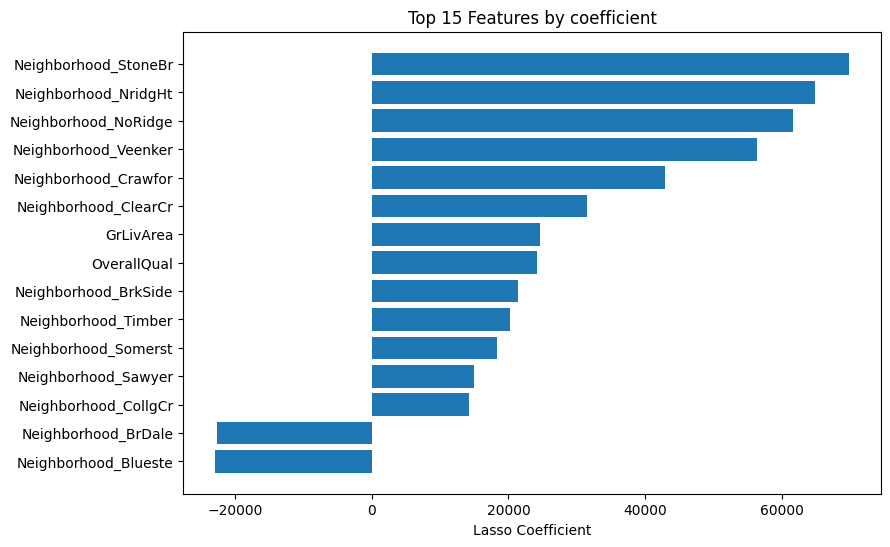

In [34]:
# Extract feature names from preprocessor
ohe = lasso_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = ohe.get_feature_names_out(categorical_cols)

all_feature_names = numerical_cols + list(cat_feature_names)
coefficients = lasso_model.named_steps['model'].coef_

coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients,
    'AbsCoeff': np.abs(coefficients)
}).sort_values('AbsCoeff', ascending=False)

display(coef_df.head(15))

# Visual weighting of features
top_n = 15
plot_df = coef_df.head(top_n).sort_values('Coefficient')

plt.figure(figsize=(9,6))
plt.barh(plot_df['Feature'], plot_df['Coefficient'])
plt.xlabel('Lasso Coefficient')
plt.title(f'Top {top_n} Features by coefficient')
plt.show()


In [20]:
feature_names = (
    numerical_cols +
    list(lasso_model.named_steps['preprocessor']
         .named_transformers_['cat']
         .get_feature_names_out(categorical_cols))
)

coefficients = lasso_model.named_steps['model'].coef_

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'AbsCoeff': np.abs(coefficients)
}).sort_values('AbsCoeff', ascending=False)

coef_df.head(10)


,Feature,Coefficient,AbsCoeff
27,Neighborhood_StoneBr,69842.280049,69842.280049
21,Neighborhood_NridgHt,64907.171117,64907.171117
20,Neighborhood_NoRidge,63341.280124,63341.280124
29,Neighborhood_Veenker,46972.951729,46972.951729
11,Neighborhood_Crawfor,38669.484719,38669.484719
3,GrLivArea,25645.772741,25645.772741
2,OverallQual,25080.636006,25080.636006
9,Neighborhood_ClearCr,22464.898271,22464.898271
7,Neighborhood_BrDale,-22338.033375,22338.033375
6,Neighborhood_Blueste,-20240.339353,20240.339353


**Visual weighting of features**

---



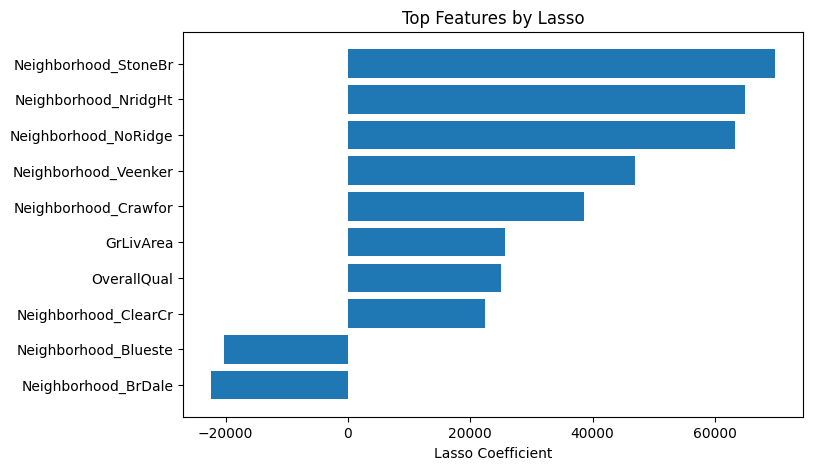

In [21]:
top_n = 10
plot_df = coef_df.head(top_n).sort_values('Coefficient')

plt.figure(figsize=(8,5))
plt.barh(plot_df['Feature'], plot_df['Coefficient'])
plt.xlabel('Lasso Coefficient')
plt.title('Top Features by Lasso')
plt.show()


Explanation:

Models such as Lasso are sensitive to the magnitude of features (features with high values in the context of features with low values). The aim of scaling is to make the features more comparable. The coefficient indicates how a feature affects the price.

Lasso evaluates influence in the model.

In [35]:
#build and evaluate models
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Keep same X, y, preprocessor from above (Version 2)
# X = df[numerical_cols + categorical_cols]
# y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 1) Linear Regression
lin_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
lin_model.fit(X_train, y_train)
lin_pred = lin_model.predict(X_test)

lin_rmse = np.sqrt(mean_squared_error(y_test, lin_pred))
lin_r2 = r2_score(y_test, lin_pred)

print("Linear Regression RMSE:", lin_rmse)
print("Linear Regression R2:", lin_r2)

# 2) Ridge Regression (this is the new feature you asked for)
ridge_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge(alpha=1.0, random_state=42))
])
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)

ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))
ridge_r2 = r2_score(y_test, ridge_pred)

print("\nRidge RMSE:", ridge_rmse)
print("Ridge R2:", ridge_r2)

# 3) 5-Fold Cross Validation for both models
kf = KFold(n_splits=5, shuffle=True, random_state=42)

lin_cv_r2 = cross_val_score(lin_model, X, y, cv=kf, scoring='r2')
ridge_cv_r2 = cross_val_score(ridge_model, X, y, cv=kf, scoring='r2')

lin_cv_rmse = np.sqrt(-cross_val_score(lin_model, X, y, cv=kf, scoring='neg_mean_squared_error'))
ridge_cv_rmse = np.sqrt(-cross_val_score(ridge_model, X, y, cv=kf, scoring='neg_mean_squared_error'))

print("\nLinear CV R2 mean:", lin_cv_r2.mean())
print("Linear CV RMSE mean:", lin_cv_rmse.mean())

print("\nRidge CV R2 mean:", ridge_cv_r2.mean())
print("Ridge CV RMSE mean:", ridge_cv_rmse.mean())


Linear Regression RMSE: 37397.59374638228
Linear Regression R2: 0.817663554294604

Ridge RMSE: 37372.9164829141
Ridge R2: 0.8179041088069857

Linear CV R2 mean: 0.777612371530673
Linear CV RMSE mean: 36537.87238918246

Ridge CV R2 mean: 0.7775532658579585
Ridge CV RMSE mean: 36522.529315300446


#Build and Evaluate Models

1.Train a Linear Regression model.

2.Evaluate using R² Score and RMSE.

3.Perform K-Fold Cross-Validation (e.g., 5-fold).

In [22]:
#train linear regression model
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

lin_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

lin_model.fit(X_train, y_train)

y_pred = lin_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R² Score:", r2)


RMSE: 37397.59374638228
R² Score: 0.817663554294604


RMSE indicates that this model is off by an average of approximately 37,397 monetary units.

R2 indicates that 82% of the variance in price (the dependent variable) is explained. More precisely:


*   Property prices fluctuate in the dataset (variance)
*   The model used can explain 82% of these fluctuations using the features.
*   18% are unexplained, i.e. errors, random values or missing features. E.g. Is there a special swimming pool, school quality in the region, level of education...


#Enhance the Model
1.Experiment with feature selection techniques and analyze their impact.

2.Visualize results (e.g., feature importance, residual plots).

In [24]:
#5 cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_r2 = cross_val_score(lin_model, X, y, cv=kf, scoring='r2')
cv_rmse = np.sqrt(-cross_val_score(
    lin_model, X, y, cv=kf, scoring='neg_mean_squared_error'
))

print("CV R² Mean:", cv_r2.mean())
print("CV RMSE Mean:", cv_rmse.mean())


CV R² Mean: 0.777612371530673
CV RMSE Mean: 36537.87238918246


In [25]:
#model enhancement with gradient boosting
gb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])

gb_r2 = cross_val_score(gb_model, X, y, cv=5, scoring='r2')
gb_rmse = np.sqrt(-cross_val_score(
    gb_model, X, y, cv=5, scoring='neg_mean_squared_error'
))

print("Gradient Boosting CV R²:", gb_r2.mean())
print("Gradient Boosting CV RMSE:", gb_rmse.mean())


Gradient Boosting CV R²: 0.8477631654280872
Gradient Boosting CV RMSE: 30729.595038788182


,Model,CV_R2_Mean,CV_RMSE_Mean
4,GradientBoosting,0.838761,0.157990
3,RandomForest,0.825969,0.164224
1,Ridge,0.818970,0.166194
0,LinearRegression,0.818694,0.166406
2,ElasticNet,0.816847,0.166938


Best model: GradientBoosting


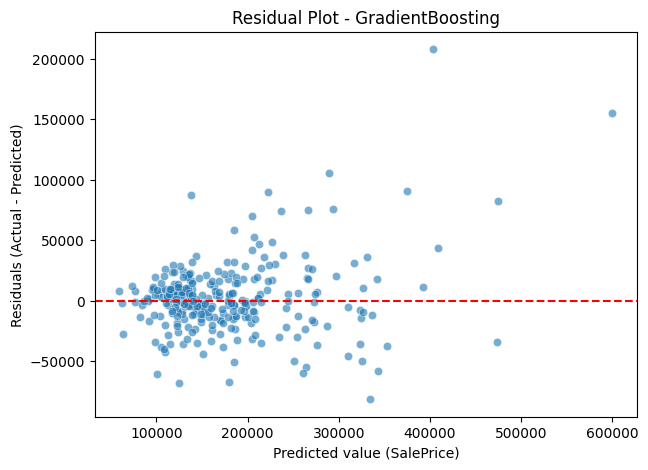

In [36]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet

# Correcting skewness using log target
y_model = np.log1p(df['SalePrice'])

X_model = df[numerical_cols + categorical_cols].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X_model, y_model, test_size=0.2, random_state=42
)

# reuse the same preprocessor (works with the same numerical_cols/categorical_cols lists)
# make sure numerical_cols and categorical_cols match X_model columns:
numerical_cols_full = X_model.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols_full = X_model.select_dtypes(include=['object']).columns.tolist()

numeric_transformer_full = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer_full = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor_full = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_full, numerical_cols_full),
        ('cat', categorical_transformer_full, categorical_cols_full)
    ]
)

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = []
for name, mdl in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor_full),
        ('model', mdl)
    ])
    r2_scores = cross_val_score(pipe, X_model, y_model, cv=kf, scoring='r2')
    rmse_scores = np.sqrt(-cross_val_score(pipe, X_model, y_model, cv=kf, scoring='neg_mean_squared_error'))
    cv_results.append((name, r2_scores.mean(), rmse_scores.mean()))

cv_results_df = pd.DataFrame(cv_results, columns=['Model', 'CV_R2_Mean', 'CV_RMSE_Mean']).sort_values('CV_R2_Mean', ascending=False)
display(cv_results_df)

best_model_name = cv_results_df.iloc[0]['Model']
print("Best model:", best_model_name)

# Fit best model for residual plot
best_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor_full),
    ('model', models[best_model_name])
])
best_pipe.fit(X_train, y_train)
pred = best_pipe.predict(X_test)

# Convert back to original space for residuals
y_test_original = np.expm1(y_test)
pred_original = np.expm1(pred)
residuals = y_test_original - pred_original

plt.figure(figsize=(7,5))
sns.scatterplot(x=pred_original, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted value (SalePrice)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title(f"Residual Plot - {best_model_name}")
plt.show()


Gradient boosting achieved the best prediction values, confirming this with an average CV-R2 of 0.83 and a parallel RMSE of 0.1578. Nevertheless, all methods are at a similarly high level.